"ZBS: Zero-shot Background Subtraction via Instance-level Background Modeling and Foreground Selection" by Yongqi An et al., CVPR 2023
|    Course: Computer Vision
|    Roll No: CS2407

In [ ]:
import torch, platform, sys
print("Python:", sys.version)
print("Torch:", torch.__version__, " CUDA available:", torch.cuda.is_available())
!nvidia-smi -L || true


Install core dependencies, Detectron2 & Detic detector

In [ ]:
# --- Colab setup ---
!pip install -q torch torchvision torchaudio
!pip install -q opencv-python matplotlib numpy imageio scipy pandas tqdm

# --- Detectron2 setup ---
!pip install -q git+https://github.com/facebookresearch/detectron2.git

!git clone https://github.com/xingyizhou/CenterNet.git /content/centernet
!git clone https://github.com/xingyizhou/CenterNet2.git /content/centernet2

!git clone https://github.com/facebookresearch/Detic.git /content/Detic
%cd /content/Detic
!pip install -q -r requirements.txt
!pip install -q -e .


Add Detic & CenterNet to Python path

In [ ]:
import sys, os
# Add Detic + centernet folders to path so Python can import modules
sys.path.append('/content/Detic')
sys.path.append('/content/centernet')
sys.path.append('/content/centernet2')

# Some centernet implementations include a 'src' folder
if os.path.isdir('/content/centernet/src'):
    sys.path.append('/content/centernet/src')
if os.path.isdir('/content/centernet2/src'):
    sys.path.append('/content/centernet2/src')

print("sys.path appended with Detic/centernet paths.")


Detic initialization

In [5]:
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.data import MetadataCatalog

# try import from detic
try:
    from detic.config import add_detic_config
    print("Imported detic.config successfully.")
except Exception as e:
    print("Importing detic.config failed:", e)
    raise

# Setup minimal config to ensure everything loads
cfg = get_cfg()
add_detic_config(cfg)
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6
cfg.MODEL.DEVICE = "cuda"
predictor = DefaultPredictor(cfg)
print("Detic DefaultPredictor created. Ready to run inference.")


/usr/local/lib/python3.12/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/usr/local/lib/python3.12/dist-packages/timm/models/helpers.py:7: FutureWarning: Importing from timm.models.helpers is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/usr/local/lib/python3.12/dist-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


Imported detic.config successfully.
Detic DefaultPredictor created. Ready to run inference.


Detic detector wrapper

In [ ]:
import numpy as np
from detectron2.data import MetadataCatalog

meta = None
try:
    meta = MetadataCatalog.get(cfg.DATASETS.TRAIN[0])
except Exception:
    meta = None

def detic_detector(img_bgr):
    out = predictor(img_bgr)
    inst = out["instances"].to("cpu")
    boxes = inst.pred_boxes.tensor.numpy() if inst.has("pred_boxes") else np.zeros((0,4))
    scores = inst.scores.numpy() if inst.has("scores") else np.zeros((0,))
    masks = inst.pred_masks.numpy() if inst.has("pred_masks") else np.zeros((0,img_bgr.shape[0],img_bgr.shape[1]), dtype=bool)
    classes = inst.pred_classes.numpy() if inst.has("pred_classes") else np.zeros((0,), dtype=int)
    names = []
    if meta is not None and meta.get("thing_classes", None):
        for c in classes:
            names.append(meta.get("thing_classes", None)[int(c)])
    else:
        names = [str(int(c)) for c in classes]
    results = []
    for b,s,m,n in zip(boxes, scores, masks, names):
        results.append({"box":[float(b[0]),float(b[1]),float(b[2]),float(b[3])],
                        "score":float(s),"mask":m.astype(np.uint8),"cls_name":n})
    return results

print("Detic initialized.")


Mount Drive & experiment parameters

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


In [8]:
# Edit these paths/params
CDNET_ROOT = "/content/drive/MyDrive/Colab Notebooks/datasets/CDNet2014/dataset"
CATEGORY = "baseline"
SEQUENCE = "PETS2006"
START_FRAME_INDEX = 920    # starting numeric index (e.g., 220)
N_FRAMES = 50              # number of consecutive frames to process
DELTA_T = 10               # update InstanceBG every DELTA_T frames
OUTPUT_DIR = "/content/drive/MyDrive/Colab Notebooks/ZBS_CDNet_results"  # where masks & CSV saved

import os
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("CDNet root:", CDNET_ROOT)
print("Processing:", CATEGORY, "/", SEQUENCE, "frames", START_FRAME_INDEX, "->", START_FRAME_INDEX+N_FRAMES-1)


CDNet root: /content/drive/MyDrive/Colab Notebooks/datasets/CDNet2014/dataset
Processing: baseline / PETS2006 frames 920 -> 969


Utilities - IOU/IOF, drawing & filename helper

In [9]:
import os, cv2, numpy as np

def bbox_area(b):
    x1,y1,x2,y2=b
    if x2<x1 or y2<y1: return 0.0
    return (x2-x1+1)*(y2-y1+1)

def bbox_intersection(a,b):
    x1,y1=max(a[0],b[0]),max(a[1],b[1])
    x2,y2=min(a[2],b[2]),min(a[3],b[3])
    if x2<x1 or y2<y1: return 0.0
    return (x2-x1+1)*(y2-y1+1)

def iou(a,b):
    inter=bbox_intersection(a,b)
    return inter/(bbox_area(a)+bbox_area(b)-inter+1e-9)

def iof(rec,bg):
    inter=bbox_intersection(rec,bg)
    return inter/(bbox_area(rec)+1e-9)

def draw_instances(img, insts):
    out = img.copy()
    for d in insts:
        x1,y1,x2,y2 = map(int, d['box'])
        cv2.rectangle(out, (x1,y1), (x2,y2), (0,220,0), 2)
        s = d.get('score', None); n = d.get('cls_name', '')
        txt = (n or "obj") + (f" {s:.2f}" if s is not None else "")
        cv2.putText(out, txt, (x1, max(0,y1-5)), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (255,255,255), 1, cv2.LINE_AA)
    return out

def frame_filename_by_index(dirpath, idx):
    want = f"{idx:06d}"
    best=None; bestdiff=1e9
    for fn in sorted(os.listdir(dirpath)):
        if not fn.lower().endswith(('.jpg','.png')): continue
        digits = ''.join([c for c in fn if c.isdigit()])
        if digits == want or digits.endswith(str(idx)):
            return os.path.join(dirpath,fn)
        if digits.isdigit():
            d = abs(int(digits)-idx)
            if d < bestdiff:
                bestdiff = d; best = fn
    if best:
        return os.path.join(dirpath,best)
    raise FileNotFoundError(f"no frame {idx} in {dirpath}")


SORT tracker

In [10]:
import numpy as np
from scipy.optimize import linear_sum_assignment

class KalmanBoxTracker:
    count = 0
    def __init__(self,bbox):
        x1,y1,x2,y2=bbox
        cx,cy=(x1+x2)/2.0,(y1+y2)/2.0
        w,h=max(1.0,x2-x1),max(1.0,y2-y1)
        self.x=np.zeros((8,1))
        self.x[0,0]=cx; self.x[1,0]=cy; self.x[2,0]=w; self.x[3,0]=h
        self.P = np.eye(8)*10.
        dt=1.
        self.F = np.eye(8)
        for i in range(4): self.F[i,i+4]=dt
        self.Q = np.eye(8)
        self.H = np.zeros((4,8)); self.H[0,0]=self.H[1,1]=self.H[2,2]=self.H[3,3]=1
        self.R = np.eye(4)*10.0
        self.time_since_update = 0
        self.id = KalmanBoxTracker.count; KalmanBoxTracker.count += 1
        self.history_bboxes=[bbox]; self.hits=1; self.age=0

    def predict(self):
        self.x = self.F @ self.x
        self.P = self.F @ self.P @ self.F.T + self.Q
        self.age += 1; self.time_since_update += 1
        cx,cy,w,h = self.x[0,0], self.x[1,0], self.x[2,0], self.x[3,0]
        return [cx-w/2.0, cy-h/2.0, cx+w/2.0, cy+h/2.0]

    def update(self, bbox):
        x1,y1,x2,y2 = bbox
        cx,cy=(x1+x2)/2.0,(y1+y2)/2.0
        w,h=max(1.0,x2-x1),max(1.0,y2-y1)
        z = np.array([[cx],[cy],[w],[h]])
        S = self.H @ self.P @ self.H.T + self.R
        K = self.P @ self.H.T @ np.linalg.inv(S)
        y = z - (self.H @ self.x)
        self.x = self.x + (K @ y)
        I = np.eye(self.P.shape[0]); self.P = (I - (K @ self.H)) @ self.P
        self.time_since_update = 0; self.hits += 1; self.history_bboxes.append(bbox)

    def get_state(self):
        cx,cy,w,h = self.x[0,0], self.x[1,0], self.x[2,0], self.x[3,0]
        return [cx-w/2.0, cy-h/2.0, cx+w/2.0, cy+h/2.0]

class Sort:
    def __init__(self, max_age=30, iou_threshold=0.3):
        self.max_age = max_age; self.iou_threshold = iou_threshold; self.trackers = []

    def update(self, dets):
        trks = [t.predict() for t in self.trackers]
        N = len(trks); M = len(dets)
        if N == 0:
            for d in dets: self.trackers.append(KalmanBoxTracker(d))
            return [(t.id, t.get_state()) for t in self.trackers]
        iou_matrix = np.zeros((N,M), dtype=np.float32)
        for i,t in enumerate(self.trackers):
            for j,d in enumerate(dets):
                iou_matrix[i,j] = iou(t.get_state(), d)
        row_ind, col_ind = linear_sum_assignment(-iou_matrix)
        assigned_trks, assigned_dets = set(), set()
        for r,c in zip(row_ind, col_ind):
            if iou_matrix[r,c] >= self.iou_threshold:
                self.trackers[r].update(dets[c])
                assigned_trks.add(r); assigned_dets.add(c)
        for j,d in enumerate(dets):
            if j not in assigned_dets:
                self.trackers.append(KalmanBoxTracker(d))
        to_del = [i for i,t in enumerate(self.trackers) if t.time_since_update > self.max_age]
        outputs = [(t.id, t.get_state()) for i,t in enumerate(self.trackers) if i not in to_del]
        for idx in sorted(to_del, reverse=True):
            del self.trackers[idx]
        return outputs


Instance-level background model & foreground selection

In [11]:
class InstanceBG:
    def __init__(self, tau_move=0.5):
        self.M = dict(); self.tau_move = tau_move

    def update_from_tracks(self, tracks_by_id, frame_idx):
        for tid, boxes in tracks_by_id.items():
            if len(boxes) < 2:
                self.M.pop(tid, None)
                continue
            arr = np.array(boxes, dtype=np.float32)
            mean_box = [float(arr[:,0].mean()), float(arr[:,1].mean()), float(arr[:,2].mean()), float(arr[:,3].mean())]
            ious = [iou(b, mean_box) for b in boxes]
            if np.median(ious) >= self.tau_move:
                self.M[tid] = {'mean_box': mean_box, 'last_seen': frame_idx}
            else:
                self.M.pop(tid, None)

    def compare_to_BG(self, box):
        out = []
        for tid, e in self.M.items():
            bg = e['mean_box']
            out.append({'tid':tid, 'bg_box':bg, 'iou': iou(box,bg), 'iof': iof(box,bg)})
        return out

def select_fg(detections, bgmodel, tau_conf=0.6, tau_fore=0.8):
    fg=[]; bg=[]
    for d in detections:
        if d['score'] < tau_conf:
            bg.append(d); continue
        comps = bgmodel.compare_to_BG(d['box'])
        if len(comps) == 0:
            fg.append(d); continue
        iou_vals = [c['iou'] for c in comps]
        iof_vals = [c['iof'] for c in comps]
        if max(iou_vals) < tau_fore and max(iof_vals) < tau_fore:
            fg.append(d)
        else:
            bg.append(d)
    return fg, bg


Run pipeline over frames and save results

In [12]:
import pandas as pd
from collections import defaultdict
from PIL import Image
from tqdm import tqdm

input_dir = os.path.join(CDNET_ROOT, CATEGORY, SEQUENCE, "input")
gt_dir = os.path.join(CDNET_ROOT, CATEGORY, SEQUENCE, "groundtruth")
assert os.path.isdir(input_dir) and os.path.isdir(gt_dir), "Input/groundtruth dirs missing - check CDNET_ROOT/CATEGORY/SEQUENCE"

sorter = Sort(max_age=30, iou_threshold=0.3)
bgmodel = InstanceBG(tau_move=0.5)
tracks_history_global = defaultdict(list)
records = []

start_idx = START_FRAME_INDEX
end_idx = START_FRAME_INDEX + N_FRAMES - 1

for frame_idx in tqdm(range(start_idx, end_idx+1), desc="Frames"):
    in_path = frame_filename_by_index(input_dir, frame_idx)
    gt_path = frame_filename_by_index(gt_dir, frame_idx)
    frame = cv2.imread(in_path)
    gt = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)
    H,W = frame.shape[:2]

    # Detic detections
    dets = detic_detector(frame)
    # clamp boxes & ensure masks present
    for d in dets:
        x1,y1,x2,y2 = map(float, d['box'])
        x1 = max(0,min(W-1,x1)); y1 = max(0,min(H-1,y1))
        x2 = max(0,min(W-1,x2)); y2 = max(0,min(H-1,y2))
        d['box'] = [x1,y1,x2,y2]
        if 'mask' not in d or d['mask'] is None:
            d['mask'] = np.zeros((H,W), dtype=np.uint8)

    # SORT update
    boxes = [d['box'] for d in dets]
    outs = sorter.update(boxes)
    for tid, tbox in outs:
        best_i, best_iou = None, 0.0
        for i,d in enumerate(dets):
            val = iou(tbox, d['box'])
            if val > best_iou:
                best_i, best_iou = i, val
        if best_i is not None:
            tracks_history_global[tid].append(dets[best_i]['box'])

    # BG update every DELTA_T frames (and at frame 0)
    local_idx = frame_idx - start_idx
    if local_idx % DELTA_T == 0:
        bgmodel.update_from_tracks(tracks_history_global, frame_idx)

    # foreground selection
    fg_dets, bg_dets = select_fg(dets, bgmodel, tau_conf=0.6, tau_fore=0.8)

    # build binary mask from fg instances
    fg_mask = np.zeros((H,W), dtype=np.uint8)
    for d in fg_dets:
        if d.get('mask', None) is not None and d['mask'].shape == (H,W):
            fg_mask = np.logical_or(fg_mask, d['mask']>0)
        else:
            x1,y1,x2,y2 = map(int, d['box'])
            y1,y2 = max(0,y1), min(H-1,y2)
            x1,x2 = max(0,x1), min(W-1,x2)
            if y2 >= y1 and x2 >= x1:
                fg_mask[y1:y2+1, x1:x2+1] = 1
    fg_mask = (fg_mask>0).astype(np.uint8) * 255

    # Evaluate vs CDNet GT: 255=foreground; treat 0/50 as background; ignore others
    valid_mask = (gt == 255) | (gt == 0) | (gt == 50)
    p = (fg_mask == 255).astype(np.uint8)
    g = (gt == 255).astype(np.uint8)
    p_valid = p[valid_mask]; g_valid = g[valid_mask]
    TP = int(np.logical_and(p_valid==1, g_valid==1).sum())
    FP = int(np.logical_and(p_valid==1, g_valid==0).sum())
    FN = int(np.logical_and(p_valid==0, g_valid==1).sum())
    prec = TP / (TP + FP + 1e-9)
    rec = TP / (TP + FN + 1e-9)
    f1 = 2*prec*rec / (prec + rec + 1e-9)

    # save outputs
    mask_out = os.path.join(OUTPUT_DIR, f"mask_{CATEGORY}_{SEQUENCE}_{frame_idx:06d}.png")
    vis_out  = os.path.join(OUTPUT_DIR, f"vis_{CATEGORY}_{SEQUENCE}_{frame_idx:06d}.jpg")
    Image.fromarray(fg_mask).save(mask_out)
    cv2.imwrite(vis_out, draw_instances(frame, dets))

    records.append({
        "frame_index": frame_idx, "input_path": in_path, "gt_path": gt_path, "mask_path": mask_out,
        "precision": float(prec), "recall": float(rec), "f1": float(f1), "TP":TP, "FP":FP, "FN":FN
    })

    print(f"Frame {frame_idx}: P={prec:.4f} R={rec:.4f} F1={f1:.4f}")

# save CSV
df = pd.DataFrame(records)
csv_out = os.path.join(OUTPUT_DIR, f"metrics_{CATEGORY}_{SEQUENCE}_{start_idx}_{end_idx}_detic.csv")
df.to_csv(csv_out, index=False)
print("Saved ZBS metrics CSV:", csv_out)
print("Mean F1 (ZBS):", df['f1'].mean() if not df.empty else "N/A")


Frames:   0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4322.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Frames:   2%|▏         | 1/50 [00:12<10:02, 12.29s/it]

Frame 920: P=0.1390 R=0.9918 F1=0.2439


Frames:   4%|▍         | 2/50 [00:14<05:12,  6.52s/it]

Frame 921: P=0.1332 R=0.9934 F1=0.2349


Frames:   6%|▌         | 3/50 [00:17<03:44,  4.77s/it]

Frame 922: P=0.1419 R=0.9982 F1=0.2485


Frames:   8%|▊         | 4/50 [00:20<03:00,  3.93s/it]

Frame 923: P=0.1377 R=0.9830 F1=0.2416


Frames:  10%|█         | 5/50 [00:23<02:43,  3.64s/it]

Frame 924: P=0.1401 R=0.9923 F1=0.2455


Frames:  12%|█▏        | 6/50 [00:25<02:24,  3.29s/it]

Frame 925: P=0.1475 R=0.9798 F1=0.2564


Frames:  14%|█▍        | 7/50 [00:28<02:17,  3.19s/it]

Frame 926: P=0.1503 R=0.9648 F1=0.2601


Frames:  16%|█▌        | 8/50 [00:31<02:13,  3.18s/it]

Frame 927: P=0.1472 R=0.9292 F1=0.2542


Frames:  18%|█▊        | 9/50 [00:34<02:02,  2.99s/it]

Frame 928: P=0.1532 R=0.9654 F1=0.2644


Frames:  20%|██        | 10/50 [00:37<01:57,  2.93s/it]

Frame 929: P=0.1588 R=0.9884 F1=0.2737


Frames:  22%|██▏       | 11/50 [00:40<01:53,  2.91s/it]

Frame 930: P=1.0000 R=0.8090 F1=0.8944


Frames:  24%|██▍       | 12/50 [00:43<01:51,  2.94s/it]

Frame 931: P=0.9998 R=0.8139 F1=0.8973


Frames:  26%|██▌       | 13/50 [01:19<08:05, 13.12s/it]

Frame 932: P=0.9956 R=0.8580 F1=0.9217


Frames:  28%|██▊       | 14/50 [01:21<05:50,  9.73s/it]

Frame 933: P=0.9988 R=0.8008 F1=0.8889


Frames:  30%|███       | 15/50 [01:23<04:20,  7.44s/it]

Frame 934: P=0.9974 R=0.8174 F1=0.8985


Frames:  32%|███▏      | 16/50 [01:25<03:17,  5.80s/it]

Frame 935: P=0.9949 R=0.8436 F1=0.9130


Frames:  34%|███▍      | 17/50 [01:27<02:32,  4.62s/it]

Frame 936: P=0.9969 R=0.8301 F1=0.9059


Frames:  36%|███▌      | 18/50 [01:29<02:01,  3.81s/it]

Frame 937: P=0.9972 R=0.8378 F1=0.9106


Frames:  38%|███▊      | 19/50 [01:31<01:40,  3.25s/it]

Frame 938: P=0.9981 R=0.7849 F1=0.8787


Frames:  40%|████      | 20/50 [01:33<01:29,  2.98s/it]

Frame 939: P=0.9697 R=0.8272 F1=0.8928


Frames:  42%|████▏     | 21/50 [01:36<01:19,  2.73s/it]

Frame 940: P=0.9948 R=0.8034 F1=0.8889


Frames:  44%|████▍     | 22/50 [01:38<01:13,  2.64s/it]

Frame 941: P=0.9966 R=0.8671 F1=0.9274


Frames:  46%|████▌     | 23/50 [01:40<01:09,  2.59s/it]

Frame 942: P=0.9956 R=0.8095 F1=0.8930


Frames:  48%|████▊     | 24/50 [01:44<01:15,  2.90s/it]

Frame 943: P=0.9946 R=0.8136 F1=0.8951


Frames:  50%|█████     | 25/50 [01:46<01:06,  2.66s/it]

Frame 944: P=0.9981 R=0.8054 F1=0.8914


Frames:  52%|█████▏    | 26/50 [01:48<00:58,  2.45s/it]

Frame 945: P=0.9959 R=0.8516 F1=0.9181


Frames:  54%|█████▍    | 27/50 [01:50<00:52,  2.27s/it]

Frame 946: P=0.9948 R=0.8004 F1=0.8870


Frames:  56%|█████▌    | 28/50 [01:52<00:47,  2.14s/it]

Frame 947: P=0.9980 R=0.8491 F1=0.9176


Frames:  58%|█████▊    | 29/50 [01:54<00:46,  2.22s/it]

Frame 948: P=0.9898 R=0.8454 F1=0.9119


Frames:  60%|██████    | 30/50 [01:57<00:45,  2.25s/it]

Frame 949: P=0.9870 R=0.8448 F1=0.9104


Frames:  62%|██████▏   | 31/50 [01:59<00:43,  2.28s/it]

Frame 950: P=0.9908 R=0.7947 F1=0.8820


Frames:  64%|██████▍   | 32/50 [02:01<00:39,  2.21s/it]

Frame 951: P=0.9890 R=0.7899 F1=0.8783


Frames:  66%|██████▌   | 33/50 [02:04<00:41,  2.42s/it]

Frame 952: P=0.9901 R=0.7650 F1=0.8631


Frames:  68%|██████▊   | 34/50 [02:06<00:36,  2.30s/it]

Frame 953: P=0.9973 R=0.8015 F1=0.8887


Frames:  70%|███████   | 35/50 [02:08<00:33,  2.24s/it]

Frame 954: P=0.9837 R=0.8064 F1=0.8863


Frames:  72%|███████▏  | 36/50 [02:10<00:30,  2.17s/it]

Frame 955: P=0.9894 R=0.7907 F1=0.8789


Frames:  74%|███████▍  | 37/50 [02:12<00:27,  2.09s/it]

Frame 956: P=0.9919 R=0.7806 F1=0.8736


Frames:  76%|███████▌  | 38/50 [02:14<00:24,  2.08s/it]

Frame 957: P=0.9917 R=0.7876 F1=0.8779


Frames:  78%|███████▊  | 39/50 [02:16<00:23,  2.11s/it]

Frame 958: P=0.9942 R=0.7989 F1=0.8859


Frames:  80%|████████  | 40/50 [02:18<00:20,  2.07s/it]

Frame 959: P=0.9954 R=0.7877 F1=0.8794


Frames:  82%|████████▏ | 41/50 [02:20<00:18,  2.02s/it]

Frame 960: P=0.9951 R=0.7852 F1=0.8778


Frames:  84%|████████▍ | 42/50 [02:22<00:16,  2.06s/it]

Frame 961: P=0.9915 R=0.7623 F1=0.8619


Frames:  86%|████████▌ | 43/50 [02:24<00:13,  1.99s/it]

Frame 962: P=0.9916 R=0.7780 F1=0.8719


Frames:  88%|████████▊ | 44/50 [02:26<00:12,  2.03s/it]

Frame 963: P=0.9923 R=0.7732 F1=0.8691


Frames:  90%|█████████ | 45/50 [02:28<00:10,  2.11s/it]

Frame 964: P=0.9934 R=0.7563 F1=0.8588


Frames:  92%|█████████▏| 46/50 [02:30<00:08,  2.09s/it]

Frame 965: P=0.9952 R=0.7372 F1=0.8470


Frames:  94%|█████████▍| 47/50 [02:32<00:06,  2.06s/it]

Frame 966: P=0.9957 R=0.8157 F1=0.8968


Frames:  96%|█████████▌| 48/50 [02:34<00:04,  2.01s/it]

Frame 967: P=0.9924 R=0.8206 F1=0.8983


Frames:  98%|█████████▊| 49/50 [02:38<00:02,  2.62s/it]

Frame 968: P=0.9937 R=0.7954 F1=0.8836


Frames: 100%|██████████| 50/50 [02:40<00:00,  3.22s/it]

Frame 969: P=0.9930 R=0.8208 F1=0.8987


Saved ZBS metrics CSV: /content/drive/MyDrive/Colab Notebooks/ZBS_CDNet_results/metrics_baseline_PETS2006_920_969_detic.csv
Mean F1 (ZBS): 0.7624773821878496


Visualization - GT vs ZBS

   frame_index  precision    recall        f1
0          920   0.139044  0.991786  0.243894
1          921   0.133173  0.993420  0.234862
2          922   0.141926  0.998150  0.248515
3          923   0.137745  0.983000  0.241631
4          924   0.140104  0.992342  0.245541
Mean F1: 0.7624773821878496


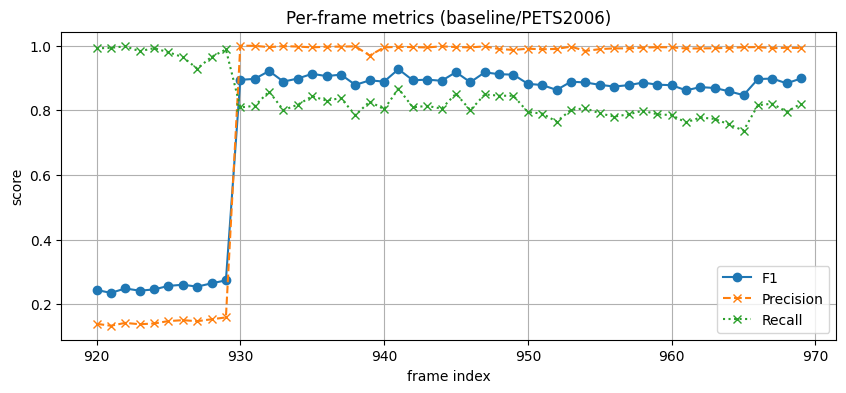

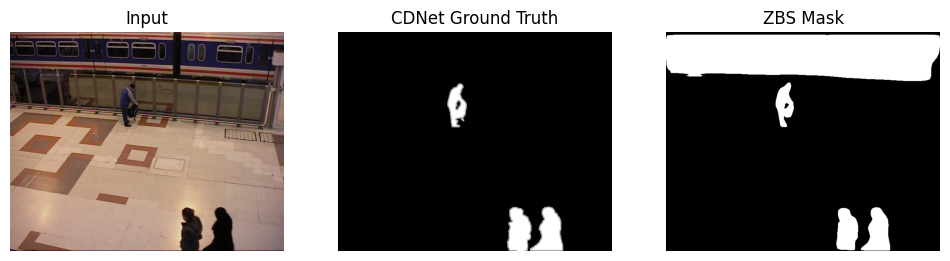

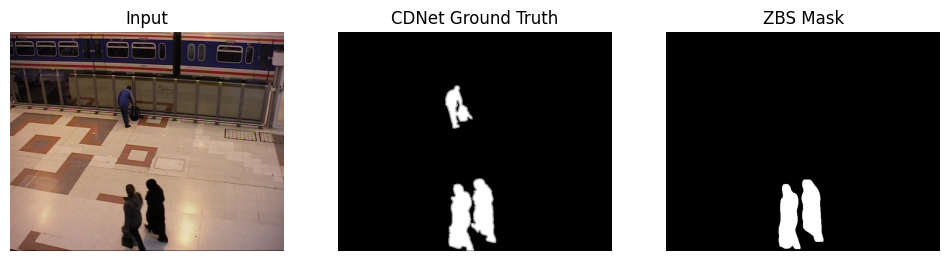

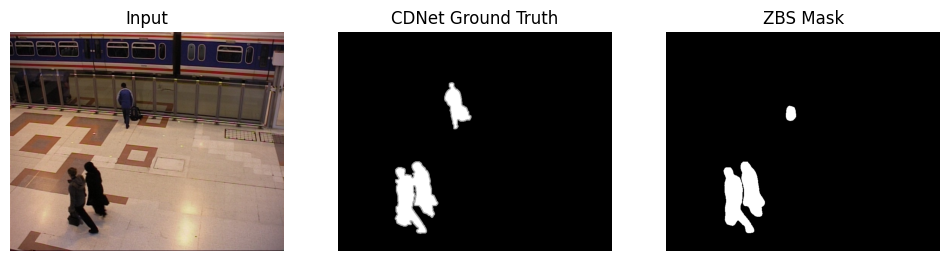

In [13]:
import matplotlib.pyplot as plt, pandas as pd, cv2
df = pd.read_csv(csv_out)
print(df[['frame_index','precision','recall','f1']].head())
print("Mean F1:", df['f1'].mean())

plt.figure(figsize=(10,4))
plt.plot(df['frame_index'], df['f1'], marker='o', label='F1')
plt.plot(df['frame_index'], df['precision'], marker='x', linestyle='--', label='Precision')
plt.plot(df['frame_index'], df['recall'], marker='x', linestyle=':', label='Recall')
plt.xlabel('frame index'); plt.ylabel('score'); plt.title(f'Per-frame metrics ({CATEGORY}/{SEQUENCE})'); plt.grid(True); plt.legend()
plt.show()

start = start_idx
mid   = (start_idx + end_idx)//2
end   = end_idx
for idx in [start, mid, end]:
    mask_path = os.path.join(OUTPUT_DIR, f"mask_{CATEGORY}_{SEQUENCE}_{idx:06d}.png")
    in_path = frame_filename_by_index(os.path.join(CDNET_ROOT, CATEGORY, SEQUENCE, "input"), idx)
    gt_path = frame_filename_by_index(os.path.join(CDNET_ROOT, CATEGORY, SEQUENCE, "groundtruth"), idx)
    img = cv2.imread(in_path)
    mask_img = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    gt_img = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.title(f"Input"); plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); plt.axis('off')
    plt.subplot(1,3,2); plt.title("CDNet Ground Truth"); plt.imshow(gt_img, cmap='gray'); plt.axis('off')
    plt.subplot(1,3,3); plt.title("ZBS Mask"); plt.imshow(mask_img, cmap='gray'); plt.axis('off')
    plt.show()


SuBSENSE implementation

In [14]:
!apt-get update -qq
!apt-get install -y -qq build-essential cmake git pkg-config libopencv-dev
!if [ ! -d "/content/bgslibrary" ]; then git clone --depth 1 https://github.com/andrewssobral/bgslibrary.git /content/bgslibrary; fi
!mkdir -p /content/bgslibrary/build
!cd /content/bgslibrary/build && cmake .. -DBUILD_EXAMPLES=ON -DBUILD_SHARED_LIBS=ON -DCMAKE_BUILD_TYPE=Release
!cd /content/bgslibrary/build && make -j$(nproc)


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
(Reading database ... 125082 files and directories currently installed.)
Removing r-base-dev (4.5.2-1.2204.0) ...
dpkg: pkgconf: dependency problems, but removing anyway as you requested:
 libsndfile1-dev:amd64 depends on pkg-config; however:
  Package pkg-config is not installed.
  Package pkgconf which provides pkg-config is to be removed.
 libopencv-dev depends on pkg-config; however:
  Package pkg-config is not installed.
  Package pkgconf which provides pkg-config is to be removed.
 libmkl-dev:amd64 depends on pkg-config; however:
  Package pkg-config is not installed.
  Package pkgconf which provides pkg-config is to be removed.
 libjack-dev depends on pkg-config; however:
  Package pkg-config is not installed.
  Package pkgconf which provides pkg-config is to be removed.
 libgphoto2-dev:amd64 

In [15]:
%%bash
echo "Rewriting run_subsense.cpp with initialization fix ..."

cat > /content/run_subsense.cpp <<'CPP'
#include <iostream>
#include <vector>
#include <string>
#include <filesystem>
#include <opencv2/opencv.hpp>
#include "/content/bgslibrary/bgslibrary/algorithms/LBSP/BackgroundSubtractorSuBSENSE.h"

using namespace std;
namespace fs = std::filesystem;

int main(int argc, char** argv){
    if(argc < 3){
        cout << "Usage: run_subsense <input_dir> <output_dir> [start_index end_index]\n";
        return 1;
    }

    string in_dir = argv[1];
    string out_dir = argv[2];
    int start = -1, end = -1;
    if(argc>=5){ start = atoi(argv[3]); end = atoi(argv[4]); }

    fs::create_directories(out_dir);

    vector<string> files;
    for (auto &p : fs::directory_iterator(in_dir)) {
        string ext = p.path().extension().string();
        if(ext==".jpg" || ext==".png" || ext==".jpeg" || ext==".JPG" || ext==".PNG")
            files.push_back(p.path().string());
    }
    sort(files.begin(), files.end());

    if(start!=-1 && end!=-1){
        vector<string> sub;
        for(auto &f: files){
            string name = fs::path(f).filename().string();
            string digits; for(char c: name) if(isdigit(c)) digits.push_back(c);
            if(!digits.empty()){ int v = stoi(digits); if(v>=start && v<=end) sub.push_back(f); }
        }
        files.swap(sub);
    }

    if(files.empty()){
        cerr << "No input frames found in " << in_dir << endl;
        return 1;
    }

    // ✅ Correct namespace
    bgslibrary::algorithms::lbsp::BackgroundSubtractorSuBSENSE subsense;

    bool initialized = false;
    int processed = 0;
    for(const auto &fpath : files){
        cv::Mat frame = cv::imread(fpath, cv::IMREAD_COLOR);
        if(frame.empty()){
            cerr << "Failed to read " << fpath << endl;
            continue;
        }

        // ✅ Initialize SuBSENSE before first use
        if(!initialized){
            subsense.initialize(frame, cv::Mat());
            initialized = true;
            cout << "SuBSENSE initialized on first frame: " << fpath << endl;
        }

        cv::Mat fgmask;
        subsense.apply(frame, fgmask);

        if(fgmask.type() != CV_8U)
            fgmask.convertTo(fgmask, CV_8U);

        string outname = out_dir + "/mask_" + fs::path(fpath).filename().string();
        cv::imwrite(outname, fgmask);
        processed++;
    }

    cout << "Processed " << processed << " frames. Masks written to " << out_dir << endl;
    return 0;
}
CPP

echo "Compiling with initialization fix..."
INCLUDES="-I /content/bgslibrary/include \
          -I /content/bgslibrary/bgslibrary \
          -I /content/bgslibrary/bgslibrary/algorithms/LBSP \
          -I /content/bgslibrary/src"
LIBDIR="-L /content/bgslibrary/build"
LIBS="-lbgslibrary_core"
PKG="$(pkg-config --cflags --libs opencv4 2>/dev/null || pkg-config --cflags --libs opencv 2>/dev/null || echo '')"

g++ -O2 -std=c++17 /content/run_subsense.cpp $INCLUDES $LIBDIR $LIBS -Wl,-rpath,/content/bgslibrary/build $PKG -o /content/run_subsense 2>&1 | tee /content/compile_log.txt | head -n 50

if [ -x /content/run_subsense ]; then
  echo "✅ Compilation successful. Runner: /content/run_subsense"
  ls -lh /content/run_subsense
else
  echo "❌ Compilation failed. See /content/compile_log.txt"
  head -n 40 /content/compile_log.txt
fi


Rewriting run_subsense.cpp with initialization fix ...
Compiling with initialization fix...
✅ Compilation successful. Runner: /content/run_subsense
-rwxr-xr-x 1 root root 39K Nov  9 16:36 /content/run_subsense


In [16]:
# Run the compiled SuBSENSE runner and evaluate masks against CDNet GT.
# Assumes /content/run_subsense exists and is executable.
import os, subprocess, cv2, numpy as np, pandas as pd
from PIL import Image
from tqdm import tqdm

# Paths (use variables from earlier cells; if missing, raise a clear error)
runner = "/content/run_subsense"
if not os.path.exists(runner) or not os.access(runner, os.X_OK):
    raise RuntimeError(f"SuBSENSE runner not found or not executable at {runner}. Re-run the compile cell.")

input_dir = os.path.join(CDNET_ROOT, CATEGORY, SEQUENCE, "input")
gt_dir    = os.path.join(CDNET_ROOT, CATEGORY, SEQUENCE, "groundtruth")
out_subsense_dir = os.path.join(OUTPUT_DIR, "subsense_masks")
os.makedirs(out_subsense_dir, exist_ok=True)

start_idx = START_FRAME_INDEX
end_idx = START_FRAME_INDEX + N_FRAMES - 1

# 1) Run runner
cmd = [runner, input_dir, out_subsense_dir, str(start_idx), str(end_idx)]
print("Running SuBSENSE runner:")
print(" ", " ".join(cmd))
proc = subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
print(proc.stdout)
if proc.returncode != 0:
    print("SuBSENSE runner failed. stderr:\n", proc.stderr)
    raise RuntimeError("run_subsense failed — see stderr above")

# 2) Load produced masks, binarize, evaluate, save unified copies in OUTPUT_DIR
records = []
for idx in tqdm(range(start_idx, end_idx+1), desc="Evaluate SuBSENSE"):
    # find input and gt using helper (keeps same logic as other cells)
    try:
        in_path = frame_filename_by_index(input_dir, idx)
        gt_path = frame_filename_by_index(gt_dir, idx)
    except Exception as e:
        print(f"Frame lookup failed for {idx}: {e}")
        continue

    base = os.path.basename(in_path)
    produced_mask = os.path.join(out_subsense_dir, "mask_" + base)
    if not os.path.exists(produced_mask):
        print(f"Warning: mask for frame {idx} not found at {produced_mask}; skipping")
        continue

    mask = cv2.imread(produced_mask, cv2.IMREAD_GRAYSCALE)
    gt   = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)
    if mask is None or gt is None:
        print(f"Warning: failed to read mask or gt for frame {idx}; skipping")
        continue

    # align sizes (rarely needed)
    if mask.shape != gt.shape:
        mask = cv2.resize(mask, (gt.shape[1], gt.shape[0]), interpolation=cv2.INTER_NEAREST)

    # binarize (any non-zero -> 255)
    mask_bin = (mask > 0).astype(np.uint8) * 255

    # evaluation rule: treat 255 = foreground; labels 0/50/85/170 -> background
    valid = (gt == 255) | (gt == 0) | (gt == 50) | (gt == 85) | (gt == 170)
    p = (mask_bin == 255).astype(np.uint8)[valid]
    g = (gt == 255).astype(np.uint8)[valid]

    TP = int(np.logical_and(p==1, g==1).sum())
    FP = int(np.logical_and(p==1, g==0).sum())
    FN = int(np.logical_and(p==0, g==1).sum())

    prec = TP / (TP + FP + 1e-9)
    rec  = TP / (TP + FN + 1e-9)
    f1   = 2 * prec * rec / (prec + rec + 1e-9)

    # save a unified copy to OUTPUT_DIR for consistent visualization naming
    unified_mask_path = os.path.join(OUTPUT_DIR, f"mask_SuBSENSE_{CATEGORY}_{SEQUENCE}_{idx:06d}.png")
    Image.fromarray(mask_bin).save(unified_mask_path)

    records.append({
        "frame_index": idx,
        "input_path": in_path,
        "gt_path": gt_path,
        "mask_path": unified_mask_path,
        "precision": float(prec),
        "recall": float(rec),
        "f1": float(f1),
        "TP": TP, "FP": FP, "FN": FN
    })

    # print progress for each frame
    print(f"Frame {idx}: P={prec:.4f} R={rec:.4f} F1={f1:.4f}")

# Save metrics CSV
df_subsense = pd.DataFrame(records)
csv_subsense = os.path.join(OUTPUT_DIR, f"metrics_SuBSENSE_{CATEGORY}_{SEQUENCE}_{start_idx}_{end_idx}.csv")
df_subsense.to_csv(csv_subsense, index=False)
print("Saved SuBSENSE metrics CSV:", csv_subsense)
print("Mean F1 (SuBSENSE):", df_subsense['f1'].mean() if not df_subsense.empty else "N/A")


Running SuBSENSE runner:
  /content/run_subsense /content/drive/MyDrive/Colab Notebooks/datasets/CDNet2014/dataset/baseline/PETS2006/input /content/drive/MyDrive/Colab Notebooks/ZBS_CDNet_results/subsense_masks 920 969
SuBSENSE initialized on first frame: /content/drive/MyDrive/Colab Notebooks/datasets/CDNet2014/dataset/baseline/PETS2006/input/in000920.jpg
Processed 50 frames. Masks written to /content/drive/MyDrive/Colab Notebooks/ZBS_CDNet_results/subsense_masks



Evaluate SuBSENSE:   2%|▏         | 1/50 [00:00<00:40,  1.20it/s]

Frame 920: P=0.0000 R=0.0000 F1=0.0000


Evaluate SuBSENSE:   4%|▍         | 2/50 [00:01<00:35,  1.36it/s]

Frame 921: P=0.7100 R=0.6212 F1=0.6626


Evaluate SuBSENSE:   6%|▌         | 3/50 [00:02<00:35,  1.31it/s]

Frame 922: P=0.6663 R=0.6774 F1=0.6718


Evaluate SuBSENSE:   8%|▊         | 4/50 [00:02<00:32,  1.42it/s]

Frame 923: P=0.6121 R=0.7181 F1=0.6608


Evaluate SuBSENSE:  10%|█         | 5/50 [00:03<00:30,  1.48it/s]

Frame 924: P=0.6011 R=0.7974 F1=0.6855


Evaluate SuBSENSE:  12%|█▏        | 6/50 [00:04<00:28,  1.54it/s]

Frame 925: P=0.5887 R=0.8121 F1=0.6826


Evaluate SuBSENSE:  14%|█▍        | 7/50 [00:04<00:28,  1.50it/s]

Frame 926: P=0.5734 R=0.8170 F1=0.6739


Evaluate SuBSENSE:  16%|█▌        | 8/50 [00:05<00:28,  1.48it/s]

Frame 927: P=0.5610 R=0.8177 F1=0.6654


Evaluate SuBSENSE:  18%|█▊        | 9/50 [00:06<00:26,  1.54it/s]

Frame 928: P=0.5666 R=0.8160 F1=0.6688


Evaluate SuBSENSE:  20%|██        | 10/50 [00:06<00:25,  1.58it/s]

Frame 929: P=0.5856 R=0.8169 F1=0.6822


Evaluate SuBSENSE:  22%|██▏       | 11/50 [00:07<00:25,  1.53it/s]

Frame 930: P=0.5989 R=0.8156 F1=0.6907


Evaluate SuBSENSE:  24%|██▍       | 12/50 [00:08<00:24,  1.56it/s]

Frame 931: P=0.6096 R=0.8139 F1=0.6971


Evaluate SuBSENSE:  26%|██▌       | 13/50 [00:19<02:29,  4.05s/it]

Frame 932: P=0.5942 R=0.8254 F1=0.6909


Evaluate SuBSENSE:  28%|██▊       | 14/50 [00:20<01:49,  3.05s/it]

Frame 933: P=0.5841 R=0.8151 F1=0.6805


Evaluate SuBSENSE:  30%|███       | 15/50 [00:21<01:21,  2.33s/it]

Frame 934: P=0.5571 R=0.8324 F1=0.6675


Evaluate SuBSENSE:  32%|███▏      | 16/50 [00:22<01:03,  1.86s/it]

Frame 935: P=0.5340 R=0.8297 F1=0.6498


Evaluate SuBSENSE:  34%|███▍      | 17/50 [00:22<00:48,  1.47s/it]

Frame 936: P=0.5143 R=0.8330 F1=0.6360


Evaluate SuBSENSE:  36%|███▌      | 18/50 [00:23<00:38,  1.21s/it]

Frame 937: P=0.4989 R=0.8271 F1=0.6224


Evaluate SuBSENSE:  38%|███▊      | 19/50 [00:23<00:32,  1.04s/it]

Frame 938: P=0.4954 R=0.8140 F1=0.6159


Evaluate SuBSENSE:  40%|████      | 20/50 [00:24<00:27,  1.10it/s]

Frame 939: P=0.4918 R=0.8252 F1=0.6163


Evaluate SuBSENSE:  42%|████▏     | 21/50 [00:25<00:24,  1.18it/s]

Frame 940: P=0.4829 R=0.8305 F1=0.6107


Evaluate SuBSENSE:  44%|████▍     | 22/50 [00:25<00:22,  1.26it/s]

Frame 941: P=0.5001 R=0.8307 F1=0.6243


Evaluate SuBSENSE:  46%|████▌     | 23/50 [00:26<00:20,  1.34it/s]

Frame 942: P=0.4906 R=0.8254 F1=0.6154


Evaluate SuBSENSE:  48%|████▊     | 24/50 [00:27<00:18,  1.41it/s]

Frame 943: P=0.4848 R=0.8196 F1=0.6092


Evaluate SuBSENSE:  50%|█████     | 25/50 [00:27<00:17,  1.46it/s]

Frame 944: P=0.4882 R=0.8227 F1=0.6128


Evaluate SuBSENSE:  52%|█████▏    | 26/50 [00:28<00:16,  1.48it/s]

Frame 945: P=0.4818 R=0.8343 F1=0.6108


Evaluate SuBSENSE:  54%|█████▍    | 27/50 [00:29<00:16,  1.43it/s]

Frame 946: P=0.4793 R=0.8311 F1=0.6080


Evaluate SuBSENSE:  56%|█████▌    | 28/50 [00:30<00:16,  1.35it/s]

Frame 947: P=0.4752 R=0.8315 F1=0.6048


Evaluate SuBSENSE:  58%|█████▊    | 29/50 [00:30<00:16,  1.27it/s]

Frame 948: P=0.4595 R=0.8234 F1=0.5898


Evaluate SuBSENSE:  60%|██████    | 30/50 [00:31<00:14,  1.35it/s]

Frame 949: P=0.4501 R=0.8203 F1=0.5813


Evaluate SuBSENSE:  62%|██████▏   | 31/50 [00:32<00:13,  1.39it/s]

Frame 950: P=0.4439 R=0.8131 F1=0.5743


Evaluate SuBSENSE:  64%|██████▍   | 32/50 [00:32<00:12,  1.43it/s]

Frame 951: P=0.4552 R=0.8083 F1=0.5824


Evaluate SuBSENSE:  66%|██████▌   | 33/50 [00:33<00:11,  1.44it/s]

Frame 952: P=0.4748 R=0.8157 F1=0.6002


Evaluate SuBSENSE:  68%|██████▊   | 34/50 [00:34<00:12,  1.27it/s]

Frame 953: P=0.4982 R=0.8208 F1=0.6201


Evaluate SuBSENSE:  70%|███████   | 35/50 [00:35<00:11,  1.32it/s]

Frame 954: P=0.4860 R=0.8183 F1=0.6098


Evaluate SuBSENSE:  72%|███████▏  | 36/50 [00:35<00:09,  1.41it/s]

Frame 955: P=0.4657 R=0.8118 F1=0.5919


Evaluate SuBSENSE:  74%|███████▍  | 37/50 [00:36<00:09,  1.32it/s]

Frame 956: P=0.4694 R=0.8129 F1=0.5951


Evaluate SuBSENSE:  76%|███████▌  | 38/50 [00:37<00:08,  1.41it/s]

Frame 957: P=0.4728 R=0.8055 F1=0.5959


Evaluate SuBSENSE:  78%|███████▊  | 39/50 [00:37<00:07,  1.45it/s]

Frame 958: P=0.4763 R=0.8073 F1=0.5992


Evaluate SuBSENSE:  80%|████████  | 40/50 [00:38<00:06,  1.47it/s]

Frame 959: P=0.4806 R=0.8044 F1=0.6017


Evaluate SuBSENSE:  82%|████████▏ | 41/50 [00:39<00:06,  1.40it/s]

Frame 960: P=0.4858 R=0.8081 F1=0.6068


Evaluate SuBSENSE:  84%|████████▍ | 42/50 [00:40<00:05,  1.45it/s]

Frame 961: P=0.4949 R=0.8108 F1=0.6147


Evaluate SuBSENSE:  86%|████████▌ | 43/50 [00:40<00:04,  1.44it/s]

Frame 962: P=0.5142 R=0.8078 F1=0.6284


Evaluate SuBSENSE:  88%|████████▊ | 44/50 [00:41<00:04,  1.50it/s]

Frame 963: P=0.5155 R=0.8052 F1=0.6286


Evaluate SuBSENSE:  90%|█████████ | 45/50 [00:41<00:03,  1.55it/s]

Frame 964: P=0.5047 R=0.8034 F1=0.6199


Evaluate SuBSENSE:  92%|█████████▏| 46/50 [00:42<00:02,  1.50it/s]

Frame 965: P=0.5074 R=0.7972 F1=0.6201


Evaluate SuBSENSE:  94%|█████████▍| 47/50 [00:43<00:02,  1.50it/s]

Frame 966: P=0.5114 R=0.7944 F1=0.6223


Evaluate SuBSENSE:  96%|█████████▌| 48/50 [00:43<00:01,  1.52it/s]

Frame 967: P=0.5079 R=0.7933 F1=0.6193


Evaluate SuBSENSE:  98%|█████████▊| 49/50 [00:44<00:00,  1.54it/s]

Frame 968: P=0.4900 R=0.7865 F1=0.6038


Evaluate SuBSENSE: 100%|██████████| 50/50 [00:45<00:00,  1.11it/s]

Frame 969: P=0.4884 R=0.7825 F1=0.6014


Saved SuBSENSE metrics CSV: /content/drive/MyDrive/Colab Notebooks/ZBS_CDNet_results/metrics_SuBSENSE_baseline_PETS2006_920_969.csv
Mean F1 (SuBSENSE): 0.6164762095720997


Visualization - GT vs SuBSENSE vs ZBS

Mean F1 -> ZBS (Detic): 0.7624773821878496
Mean F1 -> SuBSENSE   : 0.6164762095720997


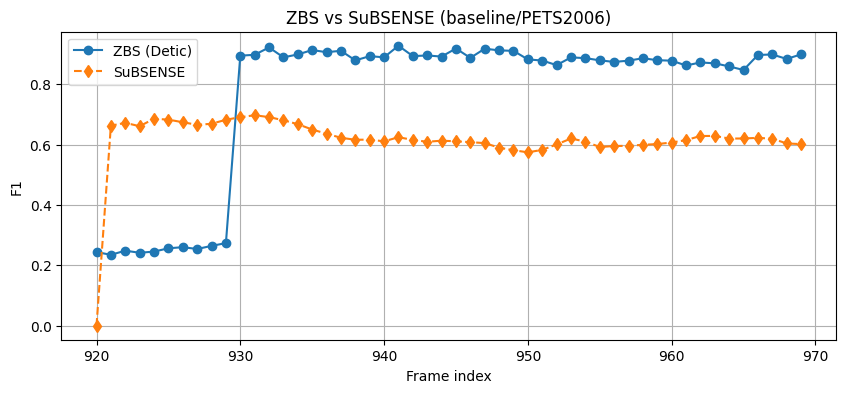

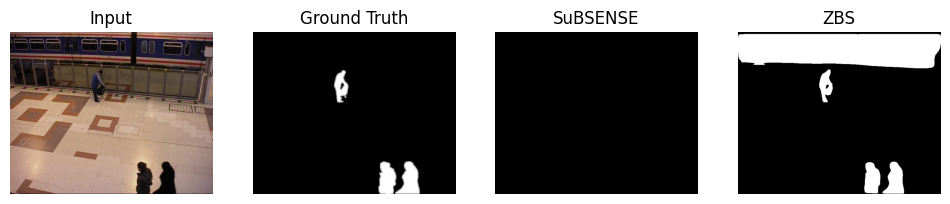

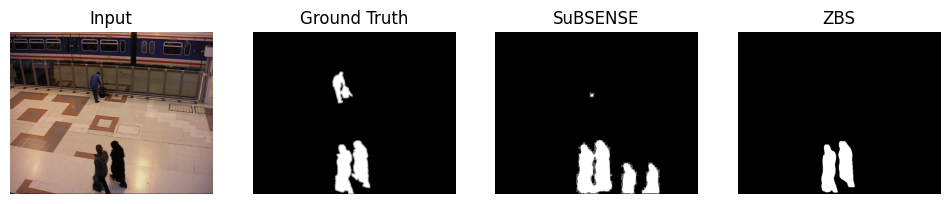

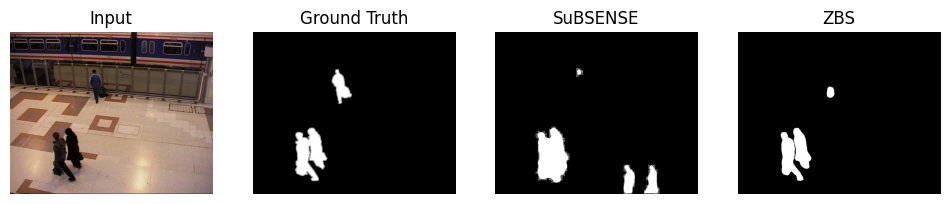

In [17]:
import os, cv2, pandas as pd, matplotlib.pyplot as plt
import numpy as np

# Load CSVs: ZBS CSV (csv_out from earlier) and SuBSENSE CSV (csv_subsense just created)
# Try to locate ZBS CSV if csv_out is not present
if 'csv_out' in globals() and os.path.exists(csv_out):
    csv_zbs = csv_out
else:
    candidate = os.path.join(OUTPUT_DIR, f"metrics_{CATEGORY}_{SEQUENCE}_{START_FRAME_INDEX}_{START_FRAME_INDEX+N_FRAMES-1}_detic.csv")
    if os.path.exists(candidate):
        csv_zbs = candidate
    else:
        # try other likely naming
        candidate2 = os.path.join(OUTPUT_DIR, f"metrics_{CATEGORY}_{SEQUENCE}_{START_FRAME_INDEX}_{START_FRAME_INDEX+N_FRAMES-1}.csv")
        csv_zbs = candidate2 if os.path.exists(candidate2) else None

if csv_zbs is None or not os.path.exists(csv_zbs):
    print("ZBS metrics CSV not found. Ensure ZBS (Detic) run completed and csv_out is available.")
    df_zbs = None
else:
    df_zbs = pd.read_csv(csv_zbs)

if not os.path.exists(csv_subsense):
    raise RuntimeError("SuBSENSE CSV missing; run Cell 12 first.")
df_sub = pd.read_csv(csv_subsense)

# Print mean F1s
if df_zbs is not None:
    print("Mean F1 -> ZBS (Detic):", df_zbs['f1'].mean())
else:
    print("ZBS (Detic) metrics unavailable.")
print("Mean F1 -> SuBSENSE   :", df_sub['f1'].mean())

# Plot per-frame F1 curves (if ZBS available plot both)
plt.figure(figsize=(10,4))
if df_zbs is not None:
    plt.plot(df_zbs['frame_index'], df_zbs['f1'], marker='o', label='ZBS (Detic)')
plt.plot(df_sub['frame_index'], df_sub['f1'], marker='d', linestyle='--', label='SuBSENSE')
plt.xlabel('Frame index'); plt.ylabel('F1'); plt.title(f'ZBS vs SuBSENSE ({CATEGORY}/{SEQUENCE})')
plt.grid(True); plt.legend(); plt.show()

# Show example frames (start, mid, end)
start = start_idx
mid = (start_idx + end_idx) // 2
end = end_idx
examples = [start, mid, end]

for idx in examples:
    try:
        in_path = frame_filename_by_index(os.path.join(CDNET_ROOT, CATEGORY, SEQUENCE, "input"), idx)
        gt_path = frame_filename_by_index(os.path.join(CDNET_ROOT, CATEGORY, SEQUENCE, "groundtruth"), idx)
    except Exception as e:
        print("Frame lookup failed for", idx, e); continue

    # ZBS mask naming (as used earlier)
    zbs_mask_path = os.path.join(OUTPUT_DIR, f"mask_{CATEGORY}_{SEQUENCE}_{idx:06d}.png")
    subs_mask_path = os.path.join(OUTPUT_DIR, f"mask_SuBSENSE_{CATEGORY}_{SEQUENCE}_{idx:06d}.png")

    img = cv2.imread(in_path)
    gt  = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)
    zbs_mask = cv2.imread(zbs_mask_path, cv2.IMREAD_GRAYSCALE) if os.path.exists(zbs_mask_path) else np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
    subs_mask = cv2.imread(subs_mask_path, cv2.IMREAD_GRAYSCALE) if os.path.exists(subs_mask_path) else np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)

    plt.figure(figsize=(12,4))
    plt.subplot(1,4,1); plt.title(f"Input"); plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); plt.axis('off')
    plt.subplot(1,4,2); plt.title("Ground Truth"); plt.imshow(gt, cmap='gray'); plt.axis('off')
    plt.subplot(1,4,3); plt.title("SuBSENSE"); plt.imshow(subs_mask, cmap='gray'); plt.axis('off')
    plt.subplot(1,4,4); plt.title("ZBS"); plt.imshow(zbs_mask, cmap='gray'); plt.axis('off')
    plt.show()


In [18]:
# Compute overall F-measure improvement (ZBS vs SuBSENSE)
import os
import glob
import pandas as pd
import numpy as np

try:
    output_dir_var = OUTPUT_DIR
except NameError:
    output_dir_var = "/content/drive/MyDrive/Colab Notebooks/ZBS_CDNet_results"

OUTPUT_DIR = output_dir_var
print("Using OUTPUT_DIR =", OUTPUT_DIR)

# Candidate filenames
zbs_csv_candidates = []
subsense_csv_candidates = []

if 'csv_out' in globals():
    zbs_csv_candidates.append(globals()['csv_out'])
if 'csv_subsense' in globals():
    subsense_csv_candidates.append(globals()['csv_subsense'])

if not zbs_csv_candidates:
    zbs_csv_candidates = sorted(glob.glob(os.path.join(OUTPUT_DIR, "*detic*.csv")) +
                                glob.glob(os.path.join(OUTPUT_DIR, "*detic*.csv.gz")) )
if not subsense_csv_candidates:
    subsense_csv_candidates = sorted(glob.glob(os.path.join(OUTPUT_DIR, "*SuBSENSE*.csv")) +
                                     glob.glob(os.path.join(OUTPUT_DIR, "*subsense*.csv")))

print("ZBS CSV candidates:", zbs_csv_candidates[:5])
print("SuBSENSE CSV candidates:", subsense_csv_candidates[:5])

if not zbs_csv_candidates:
    raise FileNotFoundError("No ZBS (detic) metrics CSV found in OUTPUT_DIR. Check previous cells.")
if not subsense_csv_candidates:
    raise FileNotFoundError("No SuBSENSE metrics CSV found in OUTPUT_DIR. Check SuBSENSE runner output.")

zbs_csv = zbs_csv_candidates[0]
subsense_csv = subsense_csv_candidates[0]

print("Loading ZBS metrics from:", zbs_csv)
print("Loading SuBSENSE metrics from:", subsense_csv)

# Read CSVs robustly
def safe_read_csv(path):
    try:
        return pd.read_csv(path)
    except Exception as e:
        # try with latin1 / engine fallback
        return pd.read_csv(path, encoding='latin1', engine='python')

df_zbs = safe_read_csv(zbs_csv)
df_subsense = safe_read_csv(subsense_csv)

# Try to locate f1 column
def find_f1_col(df):
    for c in df.columns:
        if c.lower() in ('f1','f-1','fscore','f_score','fmeasure','f_measure','f1-score'):
            return c
    # common fallback names
    if 'f1' in df.columns: return 'f1'
    if 'F1' in df.columns: return 'F1'
    return None

zbs_f1_col = find_f1_col(df_zbs)
subsense_f1_col = find_f1_col(df_subsense)

if zbs_f1_col is None:
    raise ValueError("Could not find F1 column in ZBS CSV. Columns: " + ", ".join(df_zbs.columns))
if subsense_f1_col is None:
    raise ValueError("Could not find F1 column in SuBSENSE CSV. Columns: " + ", ".join(df_subsense.columns))

# Convert to numeric and drop NaNs
zbs_f1_vals = pd.to_numeric(df_zbs[zbs_f1_col], errors='coerce').dropna().values
subsense_f1_vals = pd.to_numeric(df_subsense[subsense_f1_col], errors='coerce').dropna().values

if zbs_f1_vals.size == 0:
    raise ValueError("ZBS F1 column contains no numeric values.")
if subsense_f1_vals.size == 0:
    raise ValueError("SuBSENSE F1 column contains no numeric values.")

# Compute mean F1
zbs_mean = float(np.mean(zbs_f1_vals))
subsense_mean = float(np.mean(subsense_f1_vals))

# Compute absolute improvement and percent improvement relative to SuBSENSE
abs_diff = zbs_mean - subsense_mean
if subsense_mean != 0:
    percent_improv = (abs_diff / subsense_mean) * 100.0
else:
    percent_improv = float('inf')

# Also compute paired frame-wise improvement if CSVs align on frame_index
paired_available = False
if 'frame_index' in df_zbs.columns and 'frame_index' in df_subsense.columns:
    # inner join on frame_index
    merged = pd.merge(df_zbs[['frame_index', zbs_f1_col]],
                      df_subsense[['frame_index', subsense_f1_col]],
                      on='frame_index', how='inner', suffixes=('_zbs','_subsense'))
    if not merged.empty:
        paired_available = True
        merged[zbs_f1_col+'_zbs'] = pd.to_numeric(merged[zbs_f1_col+'_zbs'], errors='coerce')
        merged[subsense_f1_col+'_subsense'] = pd.to_numeric(merged[subsense_f1_col+'_subsense'], errors='coerce')
        mean_paired_zbs = float(merged[zbs_f1_col+'_zbs'].mean())
        mean_paired_subsense = float(merged[subsense_f1_col+'_subsense'].mean())
        paired_abs_diff = mean_paired_zbs - mean_paired_subsense
        paired_percent = (paired_abs_diff / mean_paired_subsense * 100.0) if mean_paired_subsense != 0 else float('inf')
    else:
        paired_available = False

# Print results
print("\n===== F-Measure Summary =====")
print(f"ZBS  mean F1 = {zbs_mean:.6f}  (from {zbs_f1_vals.size} frames/rows in {os.path.basename(zbs_csv)})")
print(f"SuBSENSE mean F1 = {subsense_mean:.6f}  (from {subsense_f1_vals.size} frames/rows in {os.path.basename(subsense_csv)})")
print(f"Absolute improvement (ZBS - SuBSENSE) = {abs_diff:.6f}")
if percent_improv == float('inf'):
    print("Percent improvement: SuBSENSE mean is zero -> undefined/infinite")
else:
    print(f"Percent improvement = {percent_improv:.2f}%")


Using OUTPUT_DIR = /content/drive/MyDrive/Colab Notebooks/ZBS_CDNet_results
ZBS CSV candidates: ['/content/drive/MyDrive/Colab Notebooks/ZBS_CDNet_results/metrics_baseline_PETS2006_920_969_detic.csv']
SuBSENSE CSV candidates: ['/content/drive/MyDrive/Colab Notebooks/ZBS_CDNet_results/metrics_SuBSENSE_baseline_PETS2006_920_969.csv']
Loading ZBS metrics from: /content/drive/MyDrive/Colab Notebooks/ZBS_CDNet_results/metrics_baseline_PETS2006_920_969_detic.csv
Loading SuBSENSE metrics from: /content/drive/MyDrive/Colab Notebooks/ZBS_CDNet_results/metrics_SuBSENSE_baseline_PETS2006_920_969.csv

===== F-Measure Summary =====
ZBS  mean F1 = 0.762477  (from 50 frames/rows in metrics_baseline_PETS2006_920_969_detic.csv)
SuBSENSE mean F1 = 0.616476  (from 50 frames/rows in metrics_SuBSENSE_baseline_PETS2006_920_969.csv)
Absolute improvement (ZBS - SuBSENSE) = 0.146001
Percent improvement = 23.68%
